In [ ]:
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torchvision
from torchvision import models
import torch
import torch.nn as nn
import os
import pandas as pd
import torchvision.transforms as transforms
import csv
import math
import torch.nn.functional as F
import itertools
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

class CNN(nn.Module):
    """
    Convolutional Neural Network.
    """
    def __init__(self):
        super().__init__()

        # define layers
        self.mr1_11 = nn.Conv2d(3, 3, 11, stride=2, padding=37)  # multires layer 1 -> 11x11 filter
        self.mr1_7 = nn.Conv2d(3, 3, 7, stride=2, padding=35)  # multires layer 1 -> 7x7 filter
        self.mr1_5 = nn.Conv2d(3, 3, 5, stride=2, padding=34)  # multires layer 1 -> 5x5 filter
        self.mr1_3 = nn.Conv2d(3, 3, 3, stride=2, padding=33)  # multires layer 1 -> 3x3 filter
        self.conv1 = nn.Conv2d(12, 24, 5, stride=2, padding=2)  # convolutional layer 1
        self.mr2_11 = nn.Conv2d(24, 24, 11, stride=2, padding=21)  # multires layer 2 -> 11x11 filter
        self.mr2_7 = nn.Conv2d(24, 24, 7, stride=2, padding=19)  # multires layer 2 -> 7x7 filter
        self.mr2_5 = nn.Conv2d(24, 24, 5, stride=2, padding=18)  # multires layer 2 -> 5x5 filter
        self.mr2_3 = nn.Conv2d(24, 24, 3, stride=2, padding=17)  # multires layer 2 -> 3x3 filter
        self.conv2 = nn.Conv2d(96, 192, 5, stride=2, padding=2)  # convolutional layer 2
        self.mr3_11 = nn.Conv2d(192, 192, 11, stride=2, padding=13)  # multires layer 3 -> 11x11 filter
        self.mr3_7 = nn.Conv2d(192, 192, 7, stride=2, padding=11)  # multires layer 3 -> 7x7 filter
        self.mr3_5 = nn.Conv2d(192, 192, 5, stride=2, padding=10)  # multires layer 3 -> 5x5 filter
        self.mr3_3 = nn.Conv2d(192, 192, 3, stride=2, padding=9)  # multires layer 3 -> 3x3 filter
        self.conv3 = nn.Conv2d(768, 1536, 5, stride=2, padding=2)  # convolutional layer 3
        self.fc1 = nn.Linear(1536 * 8 * 8, 512)  # fully connected layer 1
        self.fc2 = nn.Linear(512, 10) # final fully connected layer (output layer for one-hot prediction)

        self.init_weights()

    def init_weights(self):
        for conv in [self.conv1, self.conv2, self.conv3]:
            C_in = conv.weight.size(1)
            nn.init.normal_(conv.weight, 0.0, 1 / math.sqrt(5 * 5 * C_in))
            nn.init.constant_(conv.bias, 0.0)

        for mr11 in [self.mr1_11, self.mr2_11, self.mr3_11]:
            C_in = mr11.weight.size(1)
            nn.init.normal_(mr11.weight, 0.0, 1 / math.sqrt(11 * 11 * C_in))
            nn.init.constant_(mr11.bias, 0.0)

        for mr7 in [self.mr1_7, self.mr2_7, self.mr3_7]:
            C_in = mr7.weight.size(1)
            nn.init.normal_(mr7.weight, 0.0, 1 / math.sqrt(7 * 7 * C_in))
            nn.init.constant_(mr7.bias, 0.0)

        for mr5 in [self.mr1_5, self.mr2_5, self.mr3_5]:
            C_in = mr5.weight.size(1)
            nn.init.normal_(mr5.weight, 0.0, 1 / math.sqrt(5 * 5 * C_in))
            nn.init.constant_(mr5.bias, 0.0)       

        for mr3 in [self.mr1_3, self.mr2_3, self.mr3_3]:
            C_in = mr3.weight.size(1)
            nn.init.normal_(mr3.weight, 0.0, 1 / math.sqrt(3 * 3 * C_in))
            nn.init.constant_(mr3.bias, 0.0)

        # initialize parameters for fully connected layers
        for fc in [self.fc1, self.fc2]:
            F_in = fc.weight.size(1)
            nn.init.normal_(fc.weight, 0.0, 1 / math.sqrt(F_in))
            nn.init.constant_(fc.bias, 0.0)


    def forward(self, x):
        N, C, H, W = x.shape
        

        # forward pass of image through the network
        z1 = self.mr1_11(x)
        z2 = self.mr1_7(x)
        z3 = self.mr1_5(x)
        z4 = self.mr1_3(x)
        z = F.relu(torch.cat((z1,z2,z3,z4),dim=1))

        z = F.relu(self.conv1(z))
        z5 = self.mr2_11(z)
        z6 = self.mr2_7(z)
        z7 = self.mr2_5(z)
        z8 = self.mr2_3(z)
        z = F.relu(torch.cat((z5,z6,z7,z8),dim=1))

        z = F.relu(self.conv2(z))
        z9 = self.mr3_11(z)
        z10 = self.mr3_7(z)
        z11 = self.mr3_5(z)
        z12 = self.mr3_3(z)
        z = F.relu(torch.cat((z9,z10,z11,z12),dim=1))

        z = F.relu(self.conv3(z))
        z = z.view(-1, 1536 * 8 * 8)
        z = F.relu(self.fc1(z))
        z = self.fc2(z)

        return z


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
def load_pretrained(dict_path):

    Resnet18 = models.resnet18(pretrained=False)
    if (dict_path != None):
        Resnet18.load_state_dict(torch.load(dict_path))
    for param in Resnet18.parameters():
        param.requires_grad = True
    n_inputs = Resnet18.fc.in_features
    Resnet18.fc = torch.nn.Linear(512,1000)
    return Resnet18

def restore_checkpoint(model, checkpoint_dir, cuda=False, force=False, pretrain=False):
    """
    If a checkpoint exists, restores the PyTorch model from the checkpoint.
    Returns the model, the current epoch, and training losses.
    """
    def get_epoch(cp):
        return int(cp.split('epoch=')[-1].split('.checkpoint.pth.tar')[0])

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    cp_files = [file_ for file_ in os.listdir(checkpoint_dir)
                if file_.startswith('epoch=') and file_.endswith('.checkpoint.pth.tar')]
    cp_files.sort(key=lambda x: get_epoch(x))

    if not cp_files:
        print('No saved model parameters found')
        if force:
            raise Exception('Checkpoint not found')
        else:
            return model, 0, []

    # Find latest epoch
    epochs = [get_epoch(cp) for cp in cp_files]

    if not force:
        epochs = [0] + epochs
        print('Which epoch to load from? Choose from epochs below:')
        print(epochs)
        print('Enter 0 to train from scratch.')
        print(">> ", end='')
        inp_epoch = int(input())
        if inp_epoch not in epochs:
            raise Exception("Invalid epoch number")
        if inp_epoch == 0:
            print("Checkpoint not loaded")
            clear_checkpoint(checkpoint_dir)
            return model, 0, []
    else:
        print('Which epoch to load from? Choose from epochs below:')
        print(epochs)
        print(">> ", end='')
        inp_epoch = int(input())
        if inp_epoch not in epochs:
            raise Exception("Invalid epoch number")

    filename = os.path.join(checkpoint_dir, 'epoch={}.checkpoint.pth.tar'.format(inp_epoch))

    print("Loading from checkpoint {}".format(filename))

    if cuda:
        checkpoint = torch.load(filename)
    else:
        # Load GPU model on CPU
        checkpoint = torch.load(filename, map_location=lambda storage, loc: storage)

    try:
        stats = checkpoint['stats']
        if pretrain:
            model.load_state_dict(checkpoint['state_dict'], strict=False)
        else:
            model.load_state_dict(checkpoint['state_dict'])
        print("=> Successfully restored checkpoint (trained for {} epochs)".format(checkpoint['epoch']))
    except:
        print("=> Checkpoint not successfully restored")
        raise

    return model, inp_epoch, stats

config = {
        'batch_size': 24,
        'ckpt_path': '/content/drive/My Drive/MachineLearningProject2020/checkpoints_Multires_classifier/one_hot',
        'plot_name': 'Transfer_4e-2_CNN',
        'dict_path': '/content/drive/MyDrive/ResNet18.pt',
        'num_epoch': 40,
        'learning_rate': 4e-4,
}
model = CNN()
model = model.double()
print('Loading model...') 
force = config['ckpt_force'] if 'ckpt_force' in config else False
model, start_epoch, stats = restore_checkpoint(model, config['ckpt_path'], force=force)
model = model.double()

Loading model...
Which epoch to load from? Choose from epochs below:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
Enter 0 to train from scratch.
>> 9
Loading from checkpoint /content/drive/My Drive/MachineLearningProject2020/checkpoints_Multires_classifier/one_hot/epoch=9.checkpoint.pth.tar
=> Successfully restored checkpoint (trained for 9 epochs)


In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/MachineLearningProject2020/FROG_uniform_pulse_duration/Pyret_Labels_for_CNN_duration_2000_bin1_14.pkl')
FROG = np.tile(np.expand_dims(df.iloc[0,1][1898,:,:],axis = 2),[1,1,3])
true_label = df.iloc[0,2][1898]
FROG.shape
print(true_label)

14.329503236982058


In [ ]:
def predict_fn(FROG1):
    FROG1 = np.tile(np.expand_dims(FROG1[:,:,:,1],axis = 1),[1,3,1,1]) 
    FROG1 = torch.tensor(FROG1)
    return model(FROG1).detach().numpy()


In [ ]:

def predict_fn_max(FROG1):
    FROG1 = np.tile(np.expand_dims(np.expand_dims(FROG1[:,:,1],axis = 0),axis = 0),[1,3,1,1]) 
    FROG1 = torch.tensor(FROG1)
    return model(FROG1).detach().numpy()
print(predict_fn_max(FROG))
print(np.argmax(predict_fn_max(FROG)))


[[ -9.89012743 -10.47977529 -13.611941   -21.9399045  -10.56857395
   -8.76146738  -2.84455796   1.08980947   4.81445213   5.70791543]]
9


In [ ]:
!pip install lime

     |████████████████████████████████| 276kB 3.8MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283858 sha256=8d8b86de03160cefa5436e747d989f56c358929a14095a35f10a07a16464acca
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [ ]:
from lime import lime_image
import time

In [ ]:
explainer = lime_image.LimeImageExplainer()

In [ ]:
print(FROG.shape)
tmp = time.time()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(FROG, predict_fn, top_labels=2, hide_color=0, num_samples=3000)

(64, 64, 3)


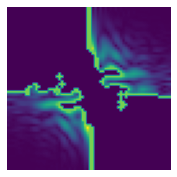

In [ ]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(9, positive_only=True, num_features=2, hide_rest=True)
fig = plt.figure()
fig.set_size_inches((3, 3))
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
plt.axis('off')
# plt.set_cmap('viridis')
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask)[:,:,0])
plt.savefig('lime65fs_hidden.png', dpi=80)



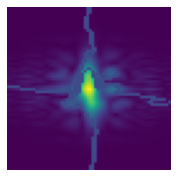

In [ ]:
temp, mask = explanation.get_image_and_mask(8, positive_only=True, num_features=2, hide_rest=False)
fig = plt.figure()
fig.set_size_inches((3, 3))
plt.axis('off')
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask)[:,:,0])
plt.savefig('lime65fs.png', dpi=80)